# Imports

In [1]:
import warnings
from osgeo import gdal
from ipywidgets import IntProgress
import glob
import random
import cv2
import numpy as np
import tensorflow as tf
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

# Reading data

In [2]:
# Get list of paths of images
orgs = sorted(glob.glob("./data/Dataset/image/*.tif")) # Images

# Get list of paths of labels
masks = sorted(glob.glob("./data/Dataset/labels/*.tif")) # Noise free labels

print(len(orgs))

print(len(masks))

1000
1000


In [3]:
# create list of indices
idx = list(range(len(orgs)))

# shuffle indices to randomize order
random.seed(12345)
random.shuffle(idx)

# shuffle lists of paths
orgs = [orgs[i] for i in idx]
masks = [masks[i] for i in idx]

print(orgs[100])
print(masks[100])

./data/Dataset/image\utm_6292_2860.tif
./data/Dataset/labels\utm_6292_2860.tif


In [4]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    diff = array.max() - array.min()
    return (array - array.min()) / diff

def read_image(path):
    raster = rasterio.open(path)
    band_2 = raster.read(2)
    band_3 = raster.read(3)
    band_4 = raster.read(4)
    
    norm_2 = normalize(band_2)
    norm_3 = normalize(band_3)
    norm_4 = normalize(band_4)
    
    x = np.dstack((norm_4, norm_3, norm_2))
    
    image = np.array(Image.fromarray((x * 255).astype(np.uint8)).resize((512, 512)).convert('RGB'))
    y = np.mean(image)
    image[np.isnan(image)] = y
    return image


def read_mask(path):
    img = gdal.Open(path)
    x = img.ReadAsArray()
    x = np.array(Image.fromarray(x.astype(np.uint8)).resize((512, 512)))
    # raster = rasterio.open(path)
    # x = raster.read(1)
    x[np.isnan(x)] = 0
    return x



In [5]:
from PIL import Image

imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(read_image(image)))
    
    im = read_mask(mask)
    masks_list.append(np.array(im))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

C:\Users\ASUS\anaconda3\envs\ten\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [6]:
print(len(imgs_np))
print(masks_np[70])

1000
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
# imgs_np[80]
#np.unique(masks_np)

In [8]:
#imgs_np.shape
#masks_np[1]

In [9]:
from keras_unet.utils import plot_imgs

#plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [10]:
#print(imgs_np.max(), masks_np.max())

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


x = np.asarray(imgs_np, dtype=np.float32)/255

y = np.asarray(masks_np, dtype=np.float32)


In [12]:
# print(x.max(), y.max())
# print(y.value_count)


In [13]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(1000, 512, 512, 3) (1000, 512, 512, 1)


In [14]:
y = to_categorical(y)

In [15]:
y[1].shape

(512, 512, 5)

In [16]:
x = np.stack(x)
print(x.shape, y.shape)
x[1]

(1000, 512, 512, 3) (1000, 512, 512, 5)


array([[[0.2901961 , 0.27450982, 0.22745098],
        [0.30980393, 0.28627452, 0.22745098],
        [0.24705882, 0.23529412, 0.18431373],
        ...,
        [0.28235295, 0.22745098, 0.1882353 ],
        [0.30980393, 0.24313726, 0.2       ],
        [0.34901962, 0.26666668, 0.22352941]],

       [[0.36078432, 0.30588236, 0.24705882],
        [0.4117647 , 0.34509805, 0.28235295],
        [0.35686275, 0.3019608 , 0.24313726],
        ...,
        [0.27450982, 0.22352941, 0.1882353 ],
        [0.3019608 , 0.23921569, 0.2       ],
        [0.34509805, 0.26666668, 0.22352941]],

       [[0.3764706 , 0.3019608 , 0.25490198],
        [0.4       , 0.32156864, 0.27058825],
        [0.37254903, 0.3019608 , 0.24705882],
        ...,
        [0.2784314 , 0.22745098, 0.1882353 ],
        [0.3137255 , 0.2509804 , 0.21176471],
        [0.34509805, 0.27450982, 0.23137255]],

       ...,

       [[0.2627451 , 0.21568628, 0.1764706 ],
        [0.2901961 , 0.23921569, 0.19607843],
        [0.30980393, 0

In [17]:
x[1].shape

(512, 512, 3)

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (800, 512, 512, 3)
y_train:  (800, 512, 512, 5)
x_val:  (200, 512, 512, 3)
y_val:  (200, 512, 512, 5)


In [19]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (800, 512, 512, 5) (5 channels).
  ' channels).')
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (800, 512, 512, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [20]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

#from keras_unet.utils import plot_imgs

#plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=4, figsize=6)

(2, 512, 512, 3) (2, 512, 512, 5)


In [21]:
# https://cdn-sv1.deepsense.ai/wp-content/uploads/2017/04/architecture_details.png
# https://deepsense.ai/deep-learning-for-satellite-imagery-via-image-segmentation/

from keras_unet import TF
if TF:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )
else:    
    from keras.models import Model
    from keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )


def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet(
    input_shape,
    num_classes=5,
    output_activation='softmax',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(5, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [22]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

# model = custom_unet(
#     input_shape,
#     use_batch_norm=False,
#     num_classes=1,
#     filters=64,
#     dropout=0.2,
#     output_activation='softmax'
# )

model = satellite_unet(input_shape=(512, 512, 3))

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)


In [25]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    #loss='binary_crossentropy',
    loss='categorical_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [26]:
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/10
50/50 [==============================] - 918s 18s/step - loss: 1.7062 - iou: 0.1215 - iou_thresholded: 0.0785 - val_loss: 6525.6846 - val_iou: 0.0911 - val_iou_thresholded: 0.0911

Epoch 00001: val_loss improved from inf to 6525.68457, saving model to segm_model_v0.h5
Epoch 2/10
50/50 [==============================] - 873s 18s/step - loss: 1.1499 - iou: 0.1940 - iou_thresholded: 0.1500 - val_loss: 1.9815 - val_iou: 0.1959 - val_iou_thresholded: 0.1276

Epoch 00002: val_loss improved from 6525.68457 to 1.98153, saving model to segm_model_v0.h5
Epoch 3/10
50/50 [==============================] - 869s 17s/step - loss: 1.4676 - iou: 0.1436 - iou_thresholded: 0.1259 - val_loss: 1.4210 - val_iou: 0.1718 - val_iou_thresholded: 0.0148

Epoch 00003: val_loss improved from 1.98153 to 1.42099, saving model to segm_model_v0.h5
Epoch 4/10
50/50 [==============================] - 870s 18s/step - loss: 1.2879 - iou: 0.1468 - iou_thresholded: 0.0470 - val_loss: 1.4843 - val_iou: 0.2116 - v

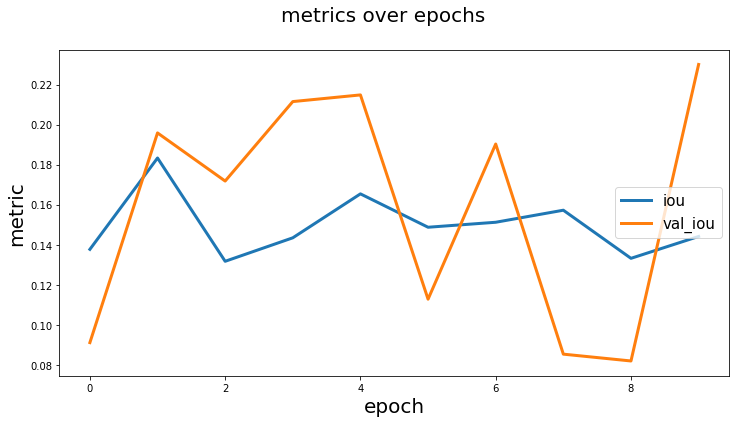

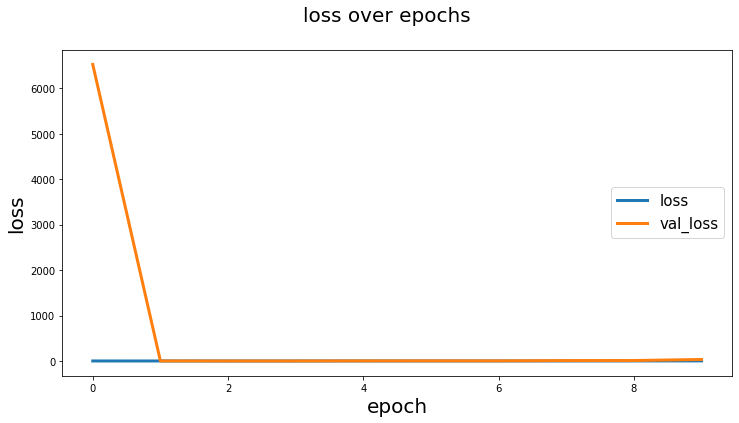

In [27]:
from keras_unet.utils import plot_segm_history

plot_segm_history(
    history, # required - keras training history object
    metrics=['iou', 'val_iou'], # optional - metrics names to plot
    losses=['loss', 'val_loss']) # optional - loss names to plot